S-learner
используем датасет из прошлой темы

In [15]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline

In [16]:
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")
df.head(1).T

,0
recency,3.000000
history,977.510000
used_discount,1.000000
used_bogo,1.000000
is_referral,1.000000
treatment,0.000000
zip_code_Rural,0.000000
zip_code_Surburban,0.000000
zip_code_Urban,1.000000
channel_Multichannel,0.000000


In [17]:

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()


In [18]:

df['old_target'] = (df['target_class'] % 2).apply(int)

df.head(2)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0,0


In [19]:
# это S-Learner
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25)

from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(verbose=0, random_state=1)
s_learner.fit(X=df_train[feature_cols + [treatment_col]],
              y=df_train[target_col])
              
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals

In [21]:
df_train[df_train['old_target']==1]

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
9188,3,236.74,1,1,0,0,1,0,0,0,1,0,0.338212,0.149336,0.319221,0.193231,0.141542,1,1
9711,1,349.65,1,0,0,0,1,0,0,0,0,1,0.421712,0.128117,0.272425,0.177745,0.323655,1,1
519,9,80.80,1,0,1,0,0,0,1,0,0,1,0.526409,0.007843,0.420034,0.045714,0.166943,1,1
4816,8,41.30,0,1,1,1,0,1,0,0,1,0,0.503418,0.011412,0.444655,0.040515,0.122682,3,1
12256,3,33.03,0,1,1,1,0,0,1,0,0,1,0.498606,0.035648,0.444569,0.021177,-0.042513,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9661,3,766.09,1,1,1,1,1,0,0,0,1,0,0.480779,0.098682,0.289787,0.130752,0.281229,3,1
7288,5,449.22,1,0,0,1,1,0,0,1,0,0,0.425733,0.097598,0.365674,0.110995,0.092723,3,1
3738,6,533.04,1,0,1,0,0,0,1,0,0,1,0.384013,0.050265,0.477920,0.087802,0.078918,1,1
9462,9,480.84,1,0,0,1,0,0,1,0,1,0,0.507371,0.014931,0.396045,0.081653,0.284685,3,1


T-LEARNER

In [22]:
t_learner_1 = LogisticRegression(verbose=0, random_state=1) # создайте логистическую регрессию с random_state=1
t_learner_0 = LogisticRegression(verbose=0, random_state=1) # создайте логистическую регрессию с random_state=1

# обучите модели
# t_learner_1 — модель, обученная на выборке с воздействием
df_train1=df_train[df_train['treatment']==1].reset_index(drop=True)
t_learner_1.fit(X=df_train1[feature_cols],y=df_train1[target_col])

# t_learner_0 — модель, обученная на выборке без воздействия
df_train0=df_train[df_train['treatment']==0].reset_index(drop=True)
t_learner_0.fit(X=df_train0[feature_cols ],y=df_train0[target_col])
# посчитайте и выведите intercept t_learner_1
# посчитайте и выведите intercept t_learner_0

print(t_learner_1.intercept_)
print(t_learner_0.intercept_)

[-1.06789173]
[-1.22884368]


Задание 2 из 2 - качество

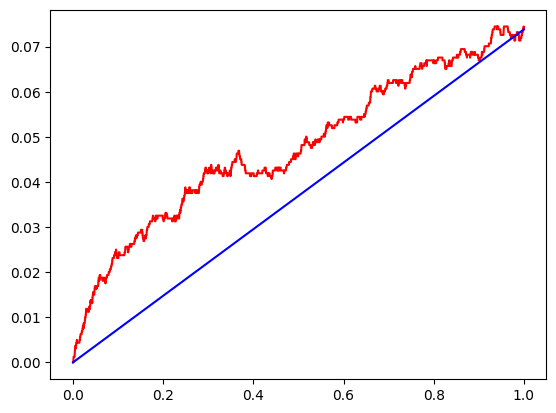

34.1297

In [24]:

df_test['yes_treatment'] = t_learner_1.predict_proba(df_test[feature_cols])[:, 1] # ваш код применения t_learner_1
df_test['no_treatment'] = t_learner_0.predict_proba(df_test[feature_cols])[:, 1]# ваш код применения t_learner_0

uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals
qini_df(df_test)